# Microbial scaling (data analysis)

After dealing with the simulated data, we now analyze the real data using the previously defined models. 

We start by fitting the distribution of division rates $\text{frac}$ with a Beta function and the distribution of growth rates $\omega_1$  with a Gamma function. In this way, we obtain 
$$
\begin{aligned}
f(\text{frac}|a, b) &= Beta(a, b) \\
f(\omega_1|c, d) &= Gamma(c, d)
\end{aligned}
$$

Applying the Bayes theorem, we can write
$$
f(\underline{\theta}|\tau, \omega_1, frac, M) \propto f(\tau, \omega_1, frac|\underline{\theta}, M)\cdot f(\underline{\theta}, M)
$$
where $M$ is the background information given by the selected model and $\theta$ the set of parameters to be inferred. In this case $\underline{\theta} = \{\mu, \nu, \omega_2, a, b, c, d\}$ and they are found by looking at the maximum of the posterior distribution. 

Regarding the likelihood, $f(\tau, \omega_1, frac|\underline{\theta})$, assuming $\tau$, $\omega_1$ and $frac$ are independent, it can be written as the product of the probability density function of each of them 
$$
f(\tau, \omega_1, frac|\underline{\theta}) = 
f(\tau|\omega_1, frac, \underline{\theta}) \cdot f(\omega_1|\tau, frac, \underline{\theta}) \cdot f(frac|\tau, \omega_1,\underline{\theta})
$$ 
where the last 2 are respectively the $Gamma(c, d)$ and $Beta(a, b)$ distributions, while the former is the probability density function of division times, which depends on the selected model and it is the derivative of the survival function $s(t)$.

#### Beyond inference
Once obtained the inferred values of the parameters $\underline{\theta}$, we can use them to generate a simulated time series. Then, the simulated division times can be compared with the real data, to find which model is statistically better.  

In [1]:
import math
import numpy as np
from scipy import stats
#import sympy as smp
from pynverse import inversefunc
import pandas as pd
# from sympy.abc import t, a, b, c, d, e
import emcee
import scipy as scp
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import seaborn as sns

from Fernando_package import functions
from Fernando_package import plot_funcs


## Import data

First, we import the real data and we create the following objects:
- `size`: length of the time series, i.e., the number of divisions 
- `xb_realdata`: initial size of the cell 
- `df_frac`: series of division ratios
- `df_growth`: series of division rates 
- `df_times`: series of inter-division times

In [2]:
df_microbial_growth = pd.read_csv('../data/modified_Susman18_physical_units.csv')
xb_realdata = df_microbial_growth['length_birth'][0]

# remove first NaN
df_microbial_growth  =  df_microbial_growth[~ np.isnan(df_microbial_growth['division_ratio'])]

# check that there is only one cell in the dataset
print('Number of cells in the dataset:', df_microbial_growth['lineage_ID'].nunique()) 

display(df_microbial_growth)
size = len(df_microbial_growth['generationtime'])

Number of cells in the dataset: 1


div_and_fold  fold_growth  division_ratio  added_length  generationtime  \
1        1.009831     0.794984        0.456028      3.198324        0.500000   
2        0.862482     0.607893        0.469619      2.291172        0.416667   
3        1.426486     1.037370        0.505526      4.632409        0.833333   
4        0.729601     0.490156        0.446903      2.028413        0.333333   
5        0.887982     0.609464        0.482744      2.121432        0.416667   
..            ...          ...             ...           ...             ...   
247      0.940427     0.590789        0.520893      2.192641        0.416667   
248      0.928602     0.604227        0.507478      2.069835        0.500000   
249      1.568073     1.046815        0.550478      4.644408        0.750000   
250      0.809727     0.481681        0.500204      2.215210        0.333333   
251      0.860970     0.711011        0.422863      2.538870        0.500000   

     length_birth  length_final  growth_rate  lineage_ID  generation  \
1        2.633655      5.831979     1.589968        15.0         1.0   
2        2.738808      5.029980     1.458944        15.0         2.0   
3        2.542786      7.175195     1.244844        15.0         3.0   
4        3.206619      5.235033     1.470468        15.0         4.0   
5        2.527183      4.648614     1.462714        15.0         5.0   
..            ...           ...          ...         ...         ...   
247      2.722385      4.915026     1.417893        15.0       249.0   
248      2.494268      4.564104     1.208453        15.0       250.0   
249      2.512440      7.156848     1.395754        15.0       251.0   
250      3.579885      5.795095     1.445043        15.0       252.0   
251      2.450531      4.989402     1.422022        15.0       253.0   

     start_time    end_time  
1      1.083333    1.583333  
2      1.666667    2.083333  
3      2.166667    3.000000  
4      3.083333    3.416667  
5      3.500000    3.916667  
..          ...         ...  
247  150.583333  151.000000  
248  151.083333  151.583333  
249  151.666667  152.416667  
250  152.500000  152.833333  
251  152.916667  153.416667  

[251 rows x 12 columns]

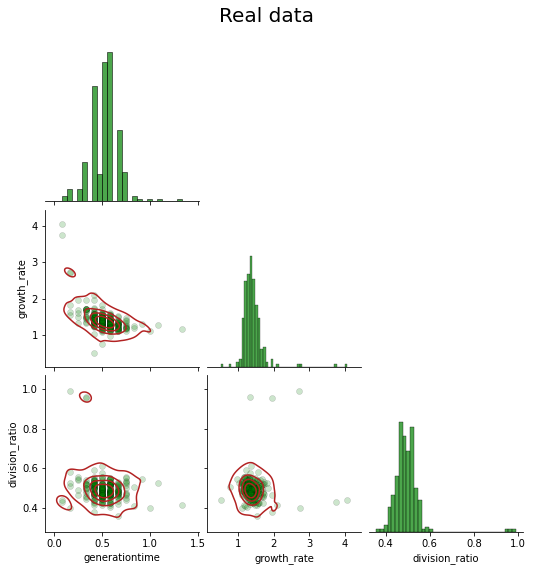

In [3]:
g = sns.pairplot(df_microbial_growth[['generationtime', 'growth_rate', 'division_ratio']], diag_kind="hist", corner=True, plot_kws={'color':'green', 'edgecolor':'black', 'alpha':0.2}, diag_kws={'color':'green', 'alpha':0.7})
g.map_lower(sns.kdeplot, levels=5, color="firebrick")
g.fig.suptitle('Real data', y=1.05, fontsize=20)
plt.show()


In [4]:
fig = plot_funcs.plot_3d_interactive(df_microbial_growth)
fig.show()

## Estimate the distribution of $\omega_1$ and frac $f$ from real data

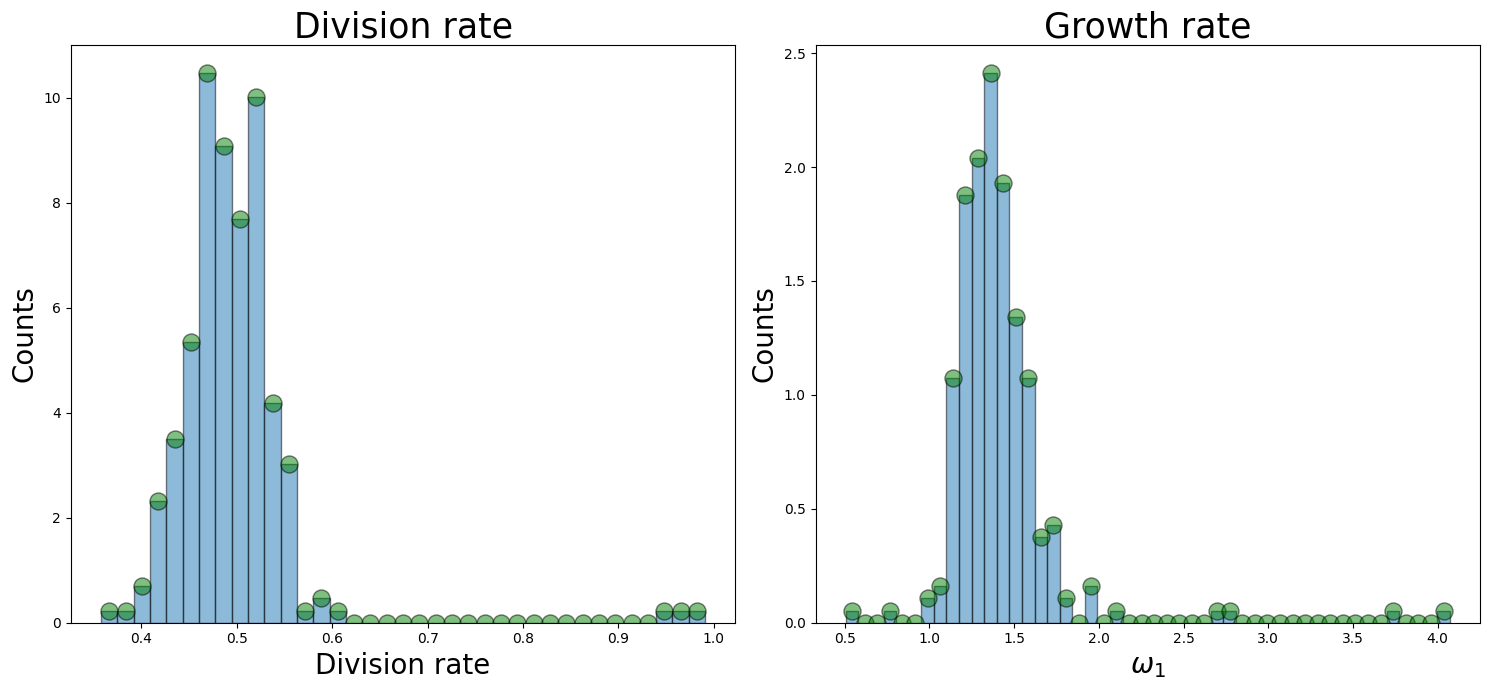

In [5]:
fig, ax = plt.subplots(1,2 , figsize=(15, 7))

hist_val_div = ax[0].hist(df_microbial_growth['division_ratio'], bins='fd', edgecolor='black', alpha=0.5, density=True)
div_centers = (hist_val_div[1][:-1] + hist_val_div[1][1:]) / 2
ax[0].scatter(div_centers, hist_val_div[0], s=150, color='green', alpha=0.5, edgecolor='black')
ax[0].set_xlabel('Division rate', fontsize=20)
ax[0].set_ylabel('Counts', fontsize=20)
ax[0].set_title('Division rate', fontsize=25)

hist_val_grow = ax[1].hist(df_microbial_growth['growth_rate'], bins='fd', edgecolor='black', alpha=0.5, density=True)
grow_centers = (hist_val_grow[1][:-1] + hist_val_grow[1][1:]) / 2
ax[1].scatter(grow_centers, hist_val_grow[0], s=150, color='green', alpha=0.5, edgecolor='black')
ax[1].set_xlabel('$\\omega_1$', fontsize=20)
ax[1].set_ylabel('Counts', fontsize=20)
ax[1].set_title('Growth rate', fontsize=25)

fig.tight_layout()

In [6]:
def fit_beta(x, a, b):
    return(scp.stats.beta.pdf(x, a=a,b=b))

def fit_gamma(x, a, teta):
    return(scp.stats.gamma.pdf(x, a=a, scale=teta))

popt_b, pcov_b = scp.optimize.curve_fit(fit_beta, xdata=div_centers, ydata = hist_val_div[0])
popt_g, pcov_g = scp.optimize.curve_fit(fit_gamma, xdata=grow_centers, ydata = hist_val_grow[0])

a_beta  = popt_b[0]; b_beta  = popt_b[1]
c_gamma = popt_g[0]; d_gamma = popt_g[1]

print('The parameters found for the beta distribution are:')
print('a =', np.round(a_beta,1),'+-', np.round(np.sqrt(pcov_b)[0,0],1))
print('b =', np.round(b_beta,1),'+-', np.round(np.sqrt(pcov_b)[1,1],1))

print('\nThe parameters found for the gamma distribution are:')
print('c =', np.round(c_gamma,1),'+-', np.round(np.sqrt(pcov_g[0,0]),1))
print('d =', np.round(d_gamma,3),'+-', np.round(np.sqrt(pcov_g[1,1]),3))


The parameters found for the beta distribution are:
a = 76.6 +- 6.0
b = 79.6 +- 6.2

The parameters found for the gamma distribution are:
c = 63.8 +- 2.6
d = 0.021 +- 0.001


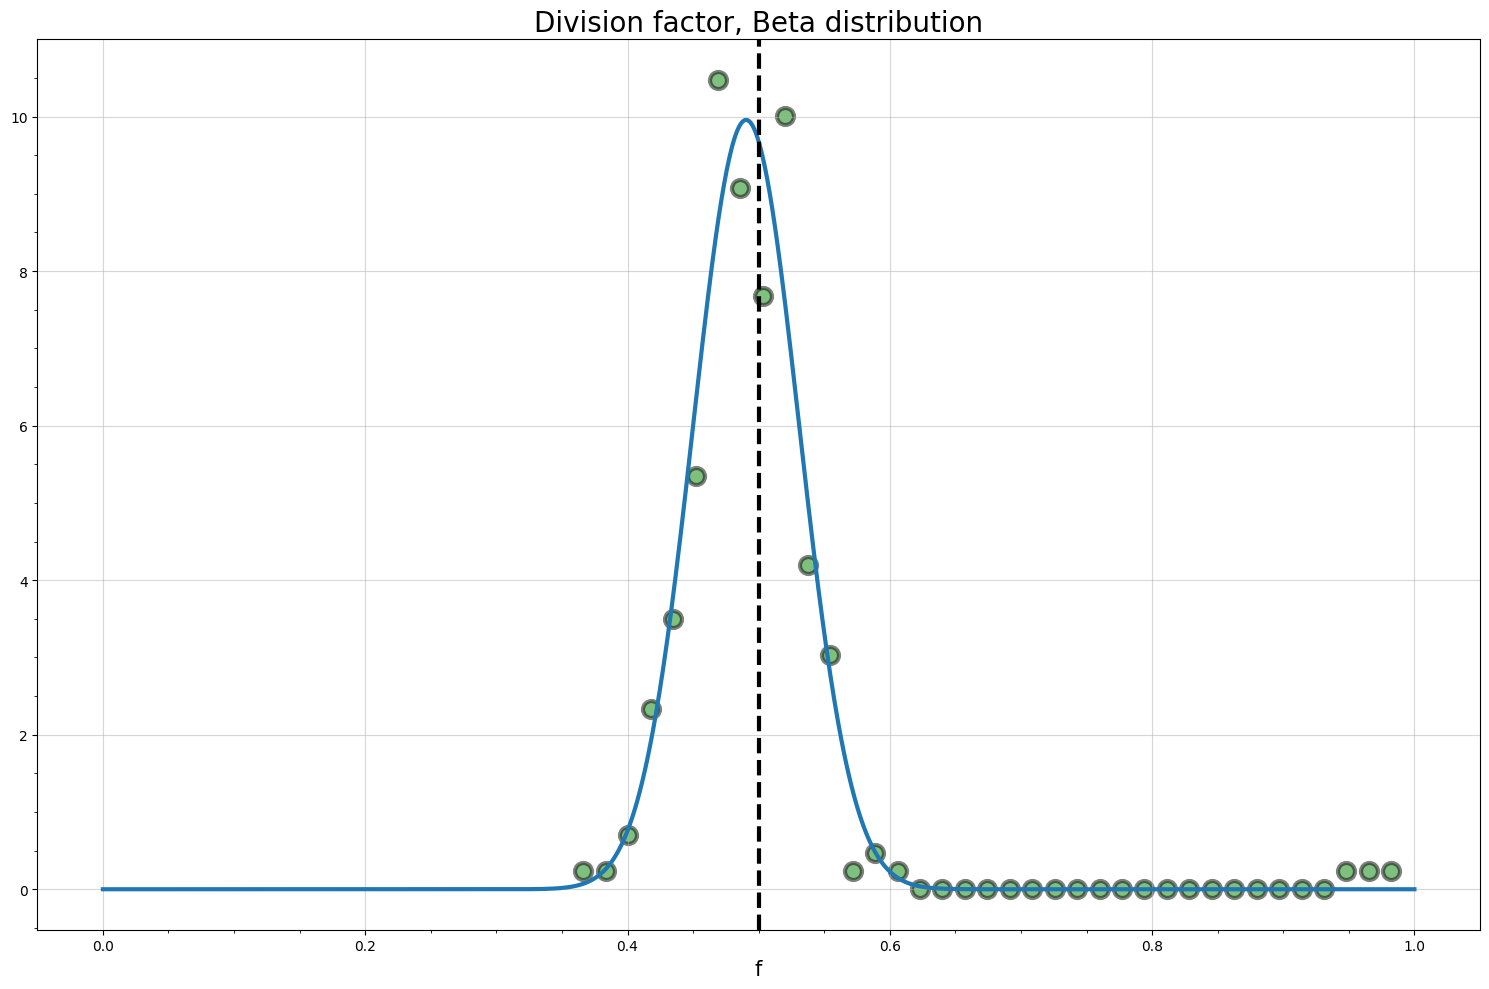

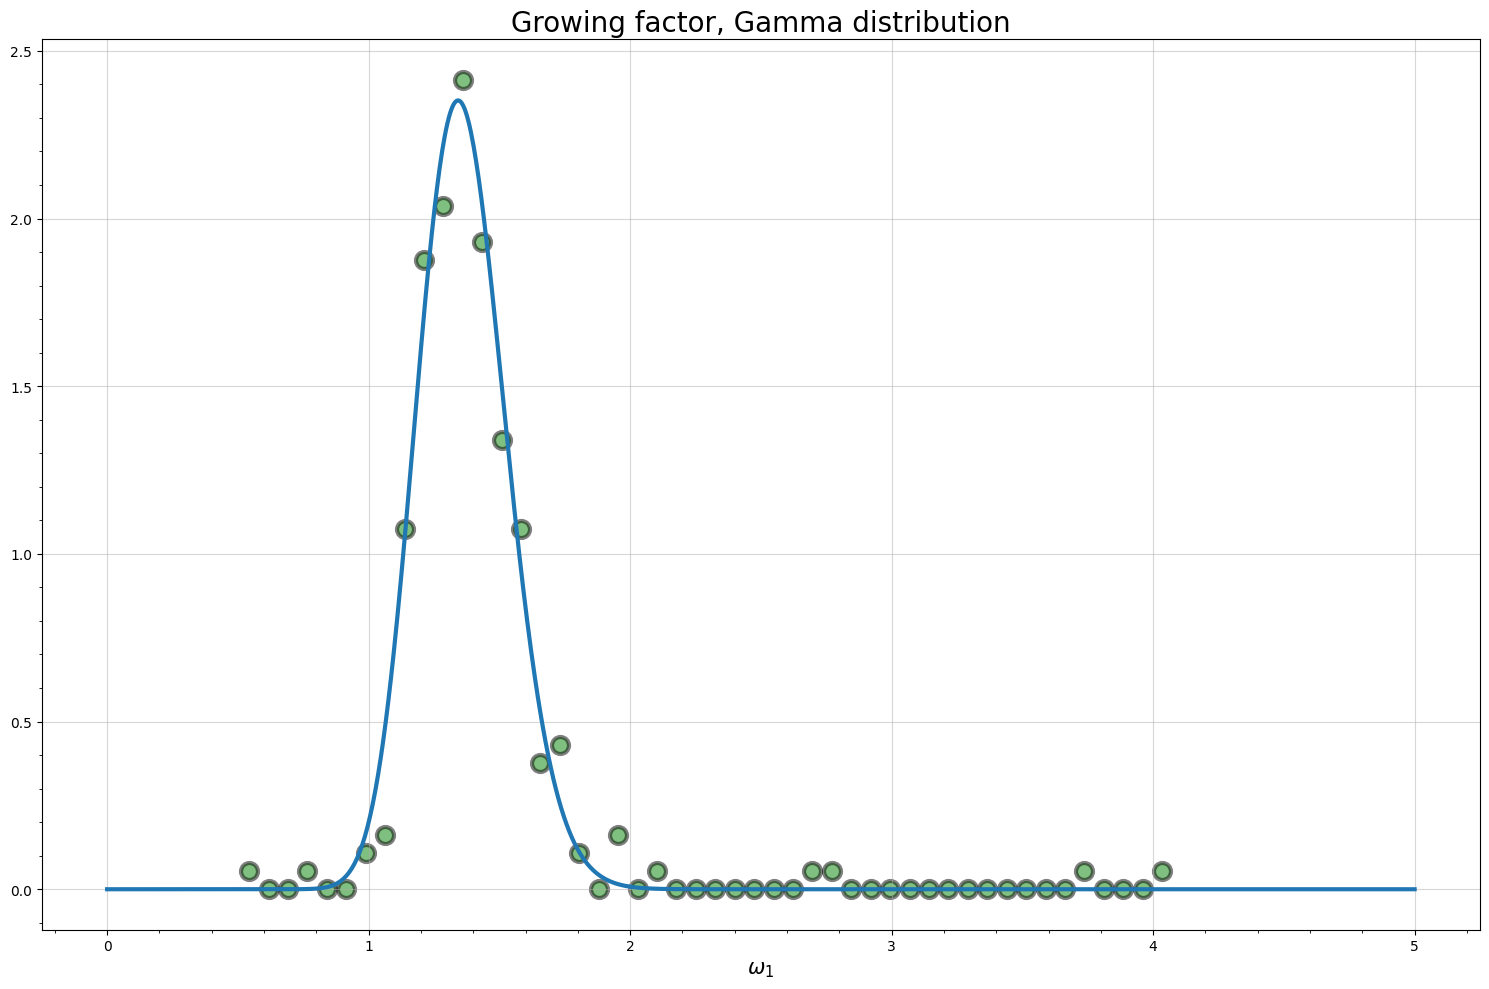

In [7]:
x_axis = np.linspace(0,1,1000)
fig, ax = plt.subplots(1,1 , figsize=(15, 10))

ax.plot(x_axis, scp.stats.beta.pdf(x_axis, a=popt_b[0],b=popt_b[1]), linewidth=3)
ax.scatter(div_centers, hist_val_div[0], linewidth=3, s=150, color='green', edgecolor = 'black', alpha=0.5)
ax.axvline(0.5, color='black', linestyle='dashed',  linewidth=3) 
ax.grid(alpha=0.5)
ax.set_title('Division factor, Beta distribution', fontsize=20)
ax.set_xlabel('f', fontsize=15)
ax.minorticks_on()
fig.tight_layout()
plt.show()

x_axis = np.linspace(0,5,1000)
fig, ax = plt.subplots(1,1 , figsize=(15, 10))

ax.plot(x_axis, scp.stats.gamma.pdf(x_axis, a=popt_g[0], scale=popt_g[1]), linewidth=3)
ax.scatter(grow_centers, hist_val_grow[0], linewidth=3, s=150, color='green', edgecolor = 'black', alpha=0.5)
ax.grid(alpha=0.5)
ax.set_title('Growing factor, Gamma distribution', fontsize=20)
ax.set_xlabel('$\omega_1$', fontsize=15)
ax.minorticks_on()
fig.tight_layout()
plt.show()


Notice that the values of the parameters $a$ and $b$ of the Beta distribution are very close to each other and as expected the distribution is almost centered around $0.5$.

# Starting model 

## Priors
We start by defining the prior distributions of our set of parameters $\underline{\theta}$. 

In [8]:
def prior_omega2(omega2):
    return(stats.lognorm.pdf(omega2, s=np.sqrt(1/3 - np.log(0.9)), loc=0, scale=np.exp(1/3 )))

def prior_mu_nu(mu, nu):
    if mu>=nu:
        return(-np.inf)
    else:
        return(np.log(stats.beta.pdf(mu, a=2, b=5))+np.log(stats.lognorm.pdf(nu, s=1/3, loc=0.1, scale=np.exp(1/9))))

def prior_a(a):
    return(stats.norm.pdf(a, loc=a_beta, scale=10*np.sqrt(10*pcov_b[0,0])))    #a for frac beta pdf

def prior_b(b):
    return(stats.norm.pdf(b, loc=b_beta, scale=10*np.sqrt(pcov_b[1,1])))    #b for frac beta pdf

def prior_c(c):
    return(stats.norm.pdf(c, loc=c_gamma, scale=10*np.sqrt(pcov_g[0,0])))   #c for w1 gamma pdf

def prior_d(d):
    return(stats.norm.pdf(d, loc=d_gamma, scale=10*np.sqrt(pcov_g[1,1])))   #d for w1 gamma pdf

priors = {
    'mu_nu': prior_mu_nu,
    'omega2': prior_omega2,
    'a': prior_a, 
    'b': prior_b, 
    'c': prior_c, 
    'd': prior_d
}

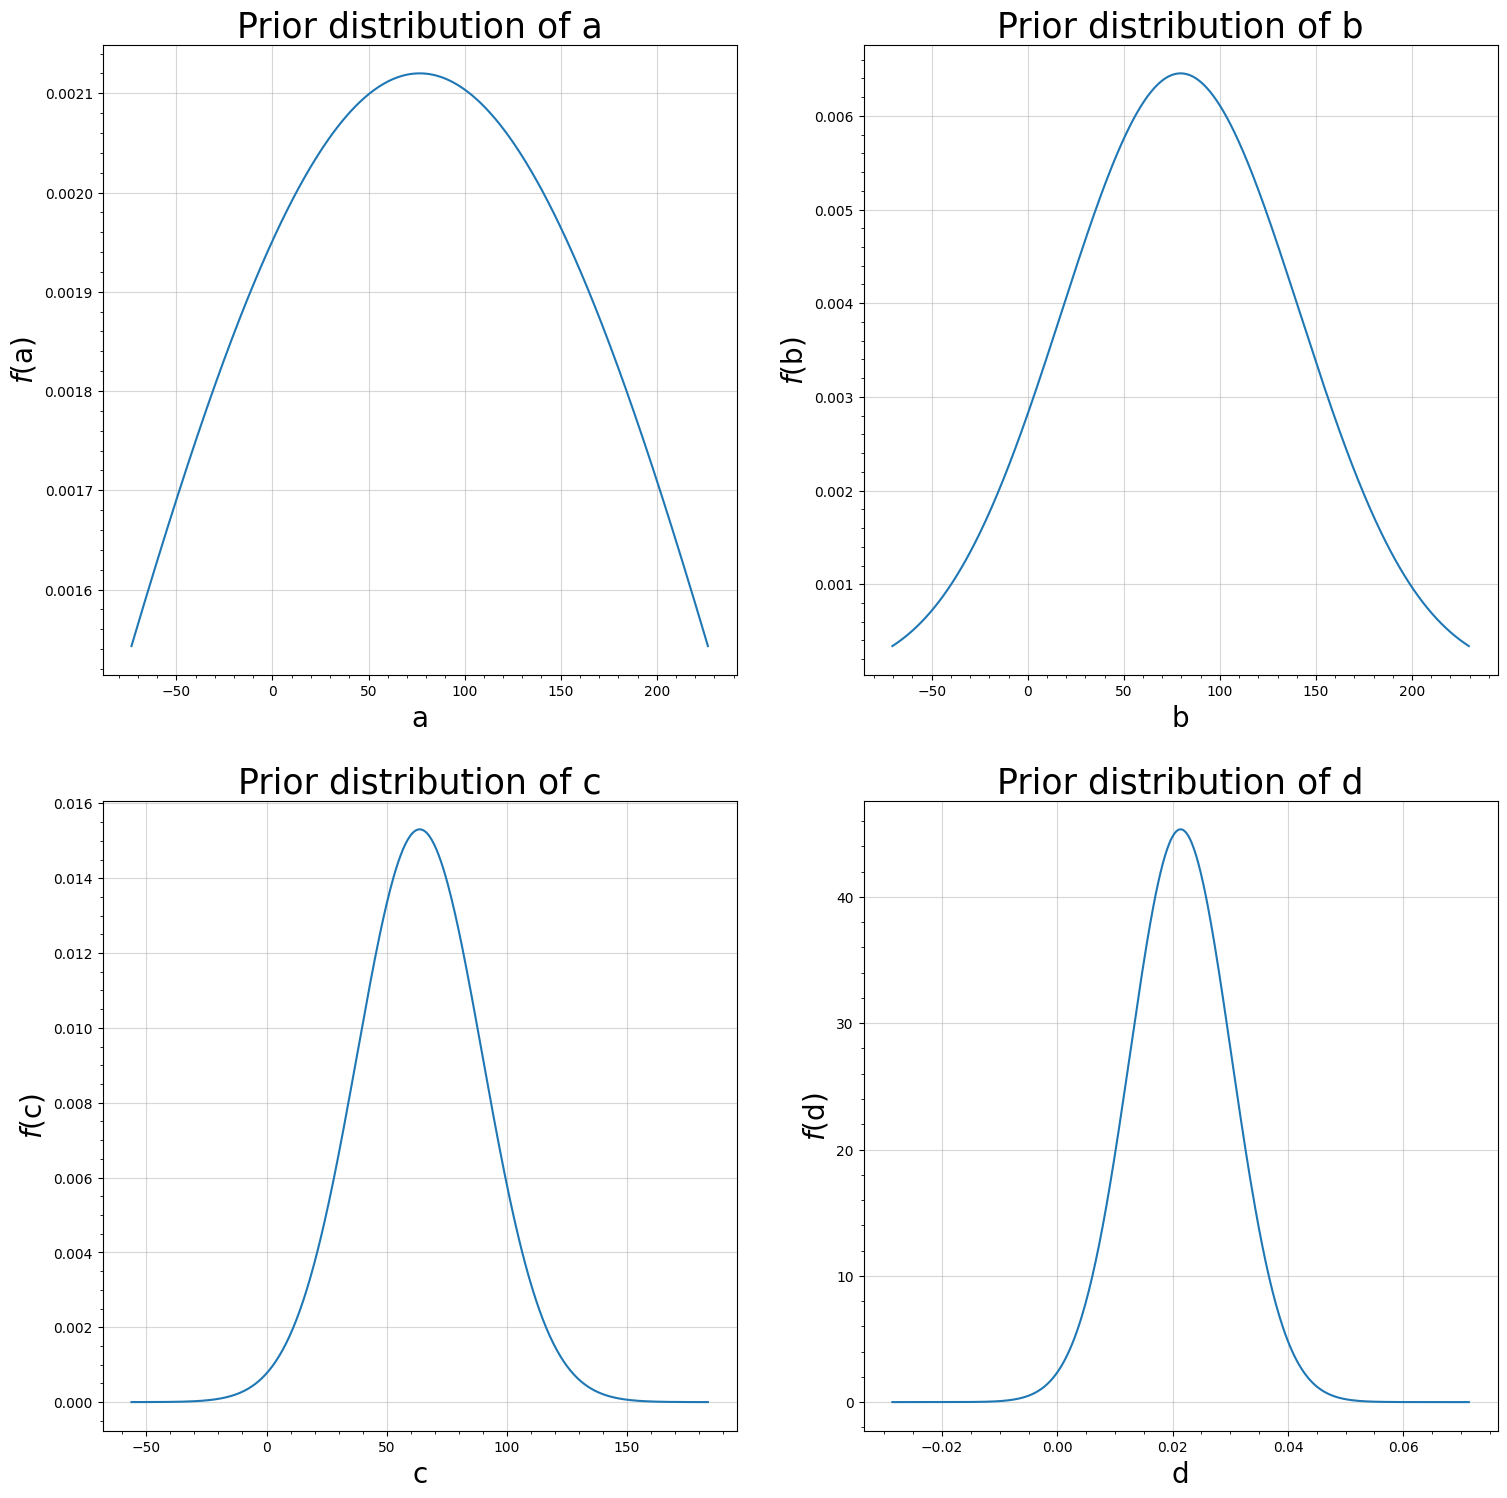

In [9]:
# plot the prior distributions of a, b, c, d
x_a_ = np.linspace(a_beta-150, a_beta+150, 500)
x_b_ = np.linspace(b_beta-150, b_beta+150, 500)
x_c_ = np.linspace(c_gamma-120, c_gamma+120, 500)
x_d_ = np.linspace(d_gamma-0.05, d_gamma+0.05, 500)

_, ax = plt.subplots(2, 2, figsize=(18, 18))
ax[0, 0].plot(x_a_, prior_a(x_a_))
ax[0, 1].plot(x_b_, prior_b(x_b_)) 
ax[1, 0].plot(x_c_, prior_c(x_c_)) 
ax[1, 1].plot(x_d_, prior_d(x_d_))

param_str = [['a', 'b'], ['c', 'd']]

for i in range(2):
    for j in range(2):
        ax[i, j].set_title('Prior distribution of ' + param_str[i][j], fontsize=25)
        ax[i, j].set_xlabel(param_str[i][j], fontsize=20)
        ax[i, j].set_ylabel('$f($'+param_str[i][j]+'$)$', fontsize=20)
        ax[i, j].minorticks_on()
        ax[i, j].grid(alpha=0.5)

## EMCEE

In [10]:
n_walkers = 20

# initial state
p0_omega_2 =np.random.uniform(low=0.5, high=1.2, size=n_walkers).reshape(-1, 1)
p0_mu = np.random.uniform(low=0.01, high=0.15, size=n_walkers).reshape(-1, 1)
p0_nu = np.random.uniform(low=0.6, high=1.3, size=n_walkers).reshape(-1, 1)
p0_a = np.random.uniform(low=a_beta, high=a_beta+np.sqrt(pcov_b[0,0]), size=n_walkers).reshape(-1,1)
p0_b = np.random.uniform(low=b_beta , high=b_beta+np.sqrt(pcov_b[1,1]), size=n_walkers).reshape(-1,1)
p0_c = np.random.uniform(low=c_gamma , high=c_gamma+np.sqrt(pcov_g[0,0]), size=n_walkers).reshape(-1,1)
p0_d = np.random.uniform(low=d_gamma , high=d_gamma+np.sqrt(pcov_g[1,1]), size=n_walkers).reshape(-1,1)

p0 = np.hstack([p0_omega_2, p0_mu, p0_nu, p0_a, p0_b, p0_c, p0_d])

#### Unnormalized posterior distribution 
To compute the posterior distribution, we use the above mentioned relations
$$
\begin{aligned}
f(\underline{\theta}|\tau, \omega_1, frac, M) &\propto f(\tau, \omega_1, frac|\underline{\theta}, M)\cdot f(\underline{\theta}, M) \\
f(\tau, \omega_1, frac|\underline{\theta}) &\propto 
f(\tau|\underline{\theta}) \cdot f(\omega_1|\underline{\theta}) \cdot f(frac|\underline{\theta})
\end{aligned}
$$
where $f(\underline{\theta}|\tau, \omega_1, frac, M)$ is the likelihood, while $f(\underline{\theta}, M)$ can be obtained as the product of the priors of each parameter. 

The actual function can be found in the file "functions.py".

In [11]:
# emcee, using real data
sampler = emcee.EnsembleSampler(
    n_walkers, 7, functions.j_log_unnorm_posterior_emcee_2, 
    kwargs={'y_times': np.array(df_microbial_growth['generationtime']), 
            'frac': np.array(df_microbial_growth['division_ratio']), 
            'omega_1': np.array(df_microbial_growth['growth_rate']), 
            'PDF': functions.PDF, 
            'h_func' : functions.h_start,
            'cdf_func' : functions.CDF_start,
            'xb': np.array(df_microbial_growth['length_birth']),
            'priors': priors}, 
    a=2
)
burn_in = 1700
n_steps = 5000

# burn-in 
pos, prob, state = sampler.run_mcmc(p0, burn_in)
sampler.reset()

# run mcmc
sampler.run_mcmc(pos, n_steps, rstate0=state)

# get chains
chain_start_sim = sampler.get_chain(flat=True)


<ipython-input-8-1c5a5a6dbebc>:8: RuntimeWarning:

divide by zero encountered in log

/work/Microbial_Scaling_Laws/analysis_real_data/Fernando_package/functions.py:339: RuntimeWarning:

divide by zero encountered in log

/work/Microbial_Scaling_Laws/analysis_real_data/Fernando_package/functions.py:333: RuntimeWarning:

divide by zero encountered in log

/work/Microbial_Scaling_Laws/analysis_real_data/Fernando_package/functions.py:42: RuntimeWarning:

overflow encountered in exp

/shared-libs/python3.8/py/lib/python3.8/site-packages/numpy/lib/function_base.py:4791: RuntimeWarning:

invalid value encountered in multiply

/work/Microbial_Scaling_Laws/analysis_real_data/Fernando_package/functions.py:333: RuntimeWarning:

invalid value encountered in log

/work/Microbial_Scaling_Laws/analysis_real_data/Fernando_package/functions.py:251: RuntimeWarning:

invalid value encountered in true_divide



In [12]:
# Original sample


# emcee, using real data
#sampler = emcee.EnsembleSampler(n_walkers, 7, functions.j_log_unnorm_posterior_emcee, 
#                                kwargs={'y_times':df_microbial_growth['generationtime'], 
#                                        'frac': df_microbial_growth['division_ratio'],
#                                        'omega_1': df_microbial_growth['growth_rate'],
#                                        'PDF': functions.PDF,
#                                        'h_func' : functions.h_start,
#                                        'cdf_func' : functions.CDF_start,
#                                        'xb': xb_realdata,
#                                        'priors': priors
#                                        },
#                                        a=2
#                                )
#burn_in = 1700
#n_steps = 5000

# burn-in 
#pos, prob, state = sampler.run_mcmc(p0, burn_in)
#sampler.reset()

# run mcmc
#sampler.run_mcmc(pos, n_steps, rstate0=state)

# get chains
#chain_mod2_sim = sampler.get_chain(flat=True)


## Results

Median value of  $\omega_2$ : 2.6397
Max value of  $\omega_2$  : 2.4804


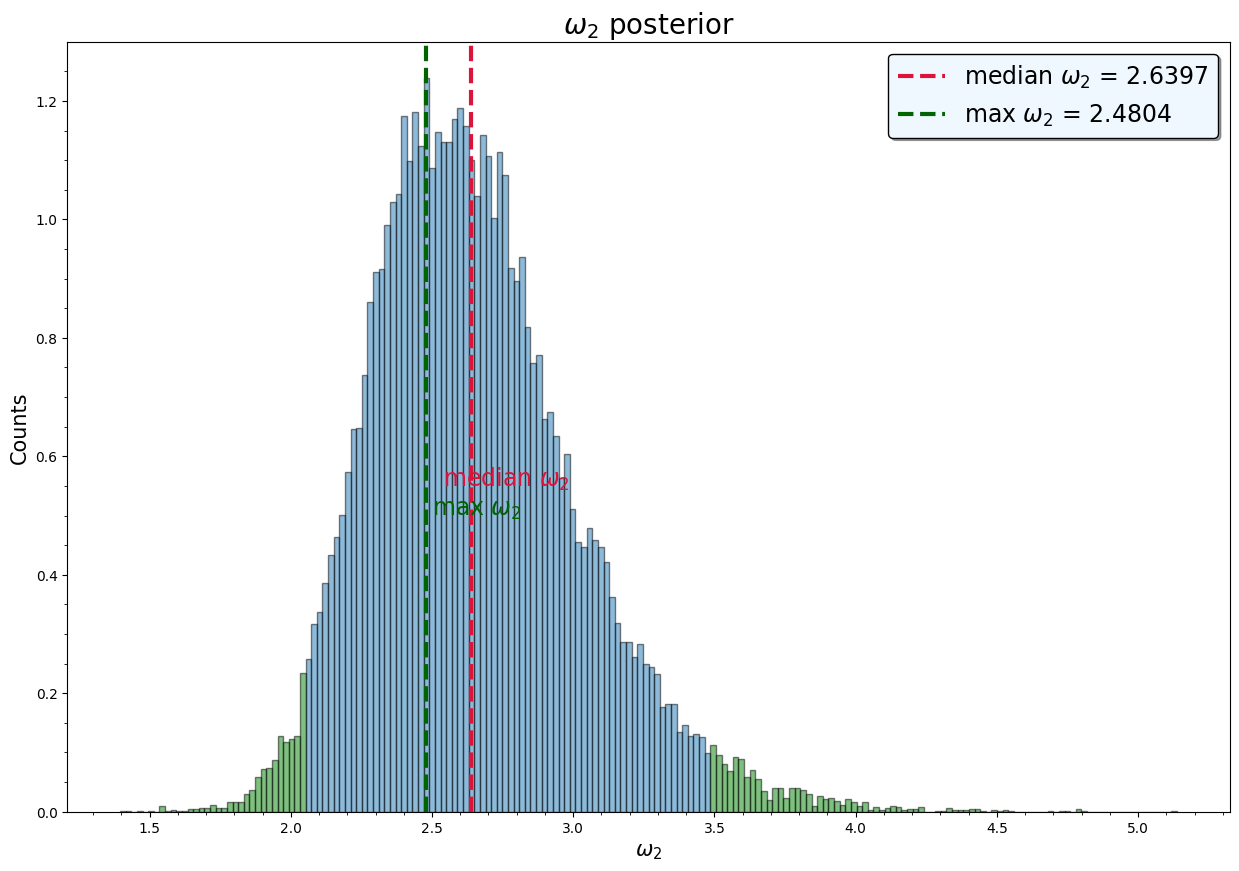

In [13]:
fig, ax, centers_omega2_s_r, counts_omega2_s_r, max_omega2 = plot_funcs.plot_func_sim(
    chain = chain_start_sim, parameter = 'omega_2', y_max=0.5, y_median=0.55, info=False
)

Median value of  $\mu$ : 0.6976
Max value of  $\mu$  : 0.6696


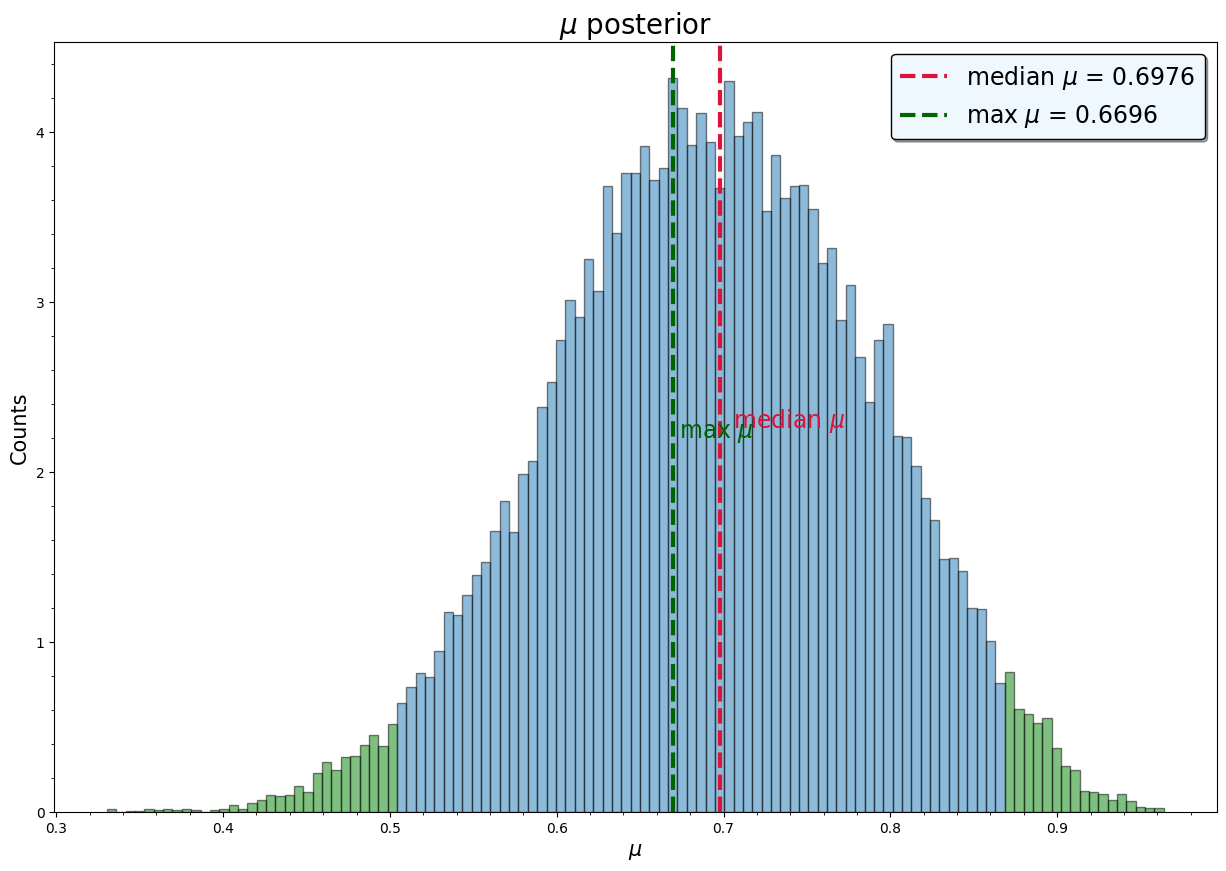

In [14]:
fig, ax, _, _, max_mu = plot_funcs.plot_func_sim(
    chain= chain_start_sim, parameter='mu', x_median= 0.008, x_max=0.004, info=False
)

Median value of  $\nu$ : 0.725
Max value of  $\nu$  : 0.7374


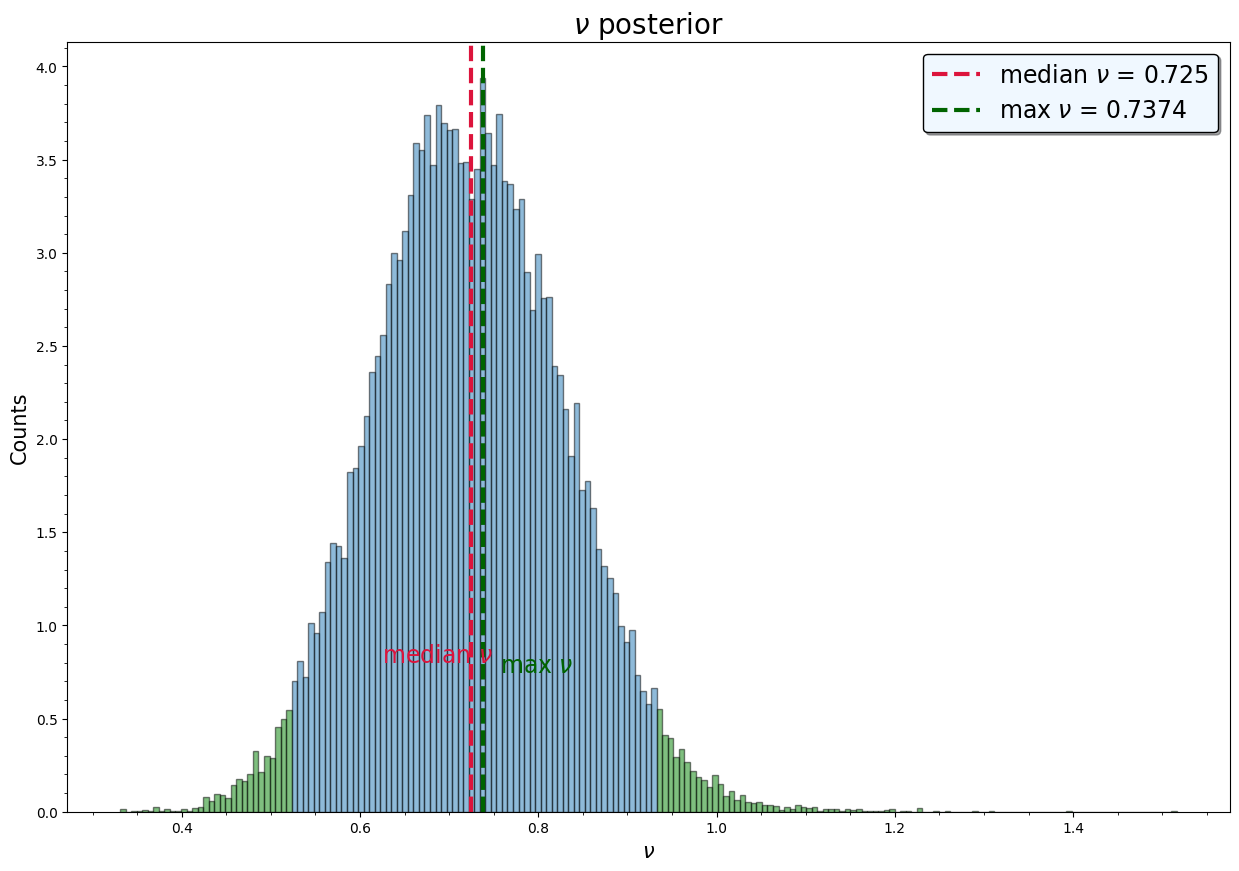

In [15]:
fig, ax, centers_nu_s_r, counts_nu_s_r, max_nu = plot_funcs.plot_func_sim(
    chain= chain_start_sim, parameter='nu', y_max=0.75, y_median=0.8, info=False
)

Median value of  a : 15.0114
Max value of  a  : 15.0841


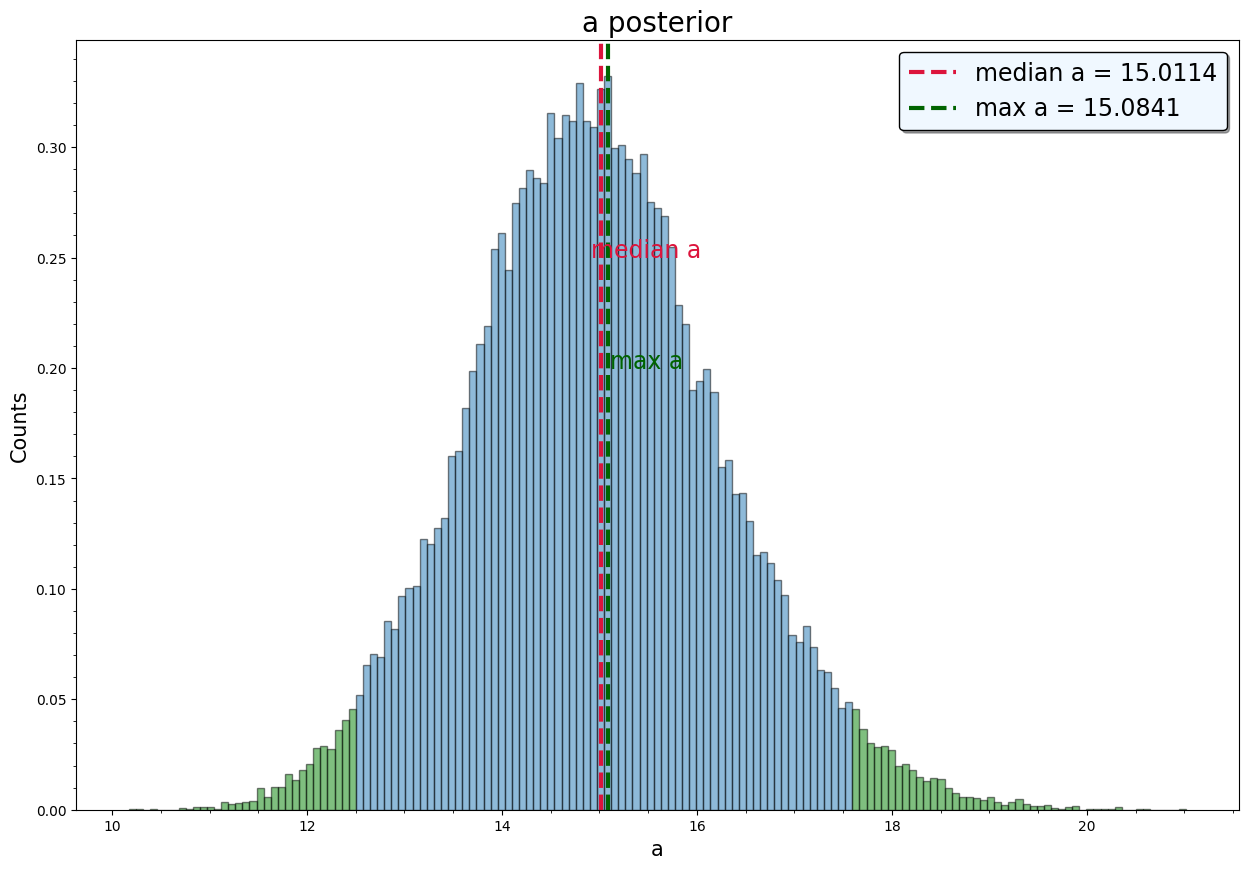

In [16]:
fig, ax, centers_a_s_r, counts_a_s_r, max_a = plot_funcs.plot_func_sim(
    chain= chain_start_sim, parameter='a' , y_max=0.2 , y_median= 0.25, info=False
)

Median value of  b : 14.9487
Max value of  b  : 14.9487


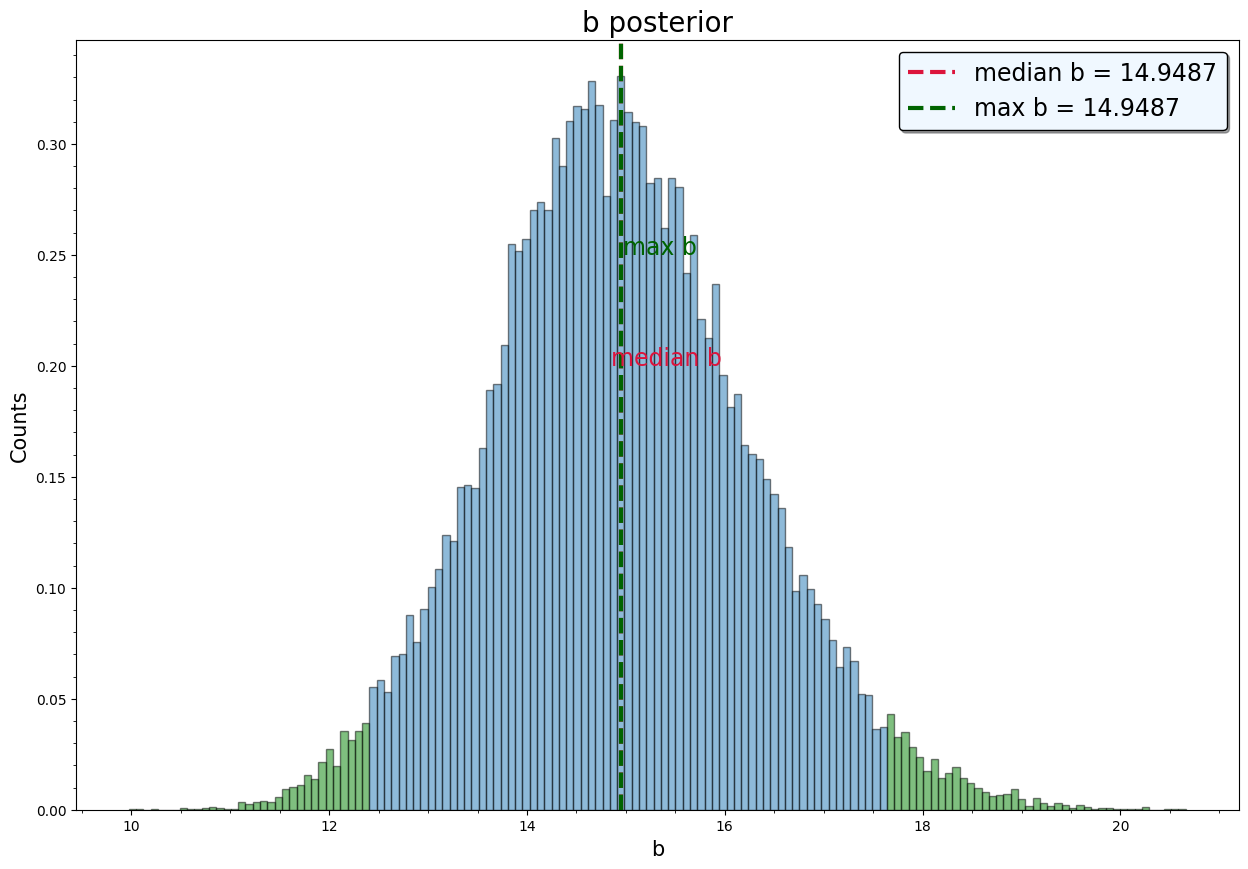

In [17]:
fig, ax, centers_b_s_r, counts_b_s_r, max_b = plot_funcs.plot_func_sim(
    chain= chain_start_sim, parameter='b', y_max=0.25, y_median=0.2, info=False
)

Median value of  c : 30.6682
Max value of  c  : 30.171


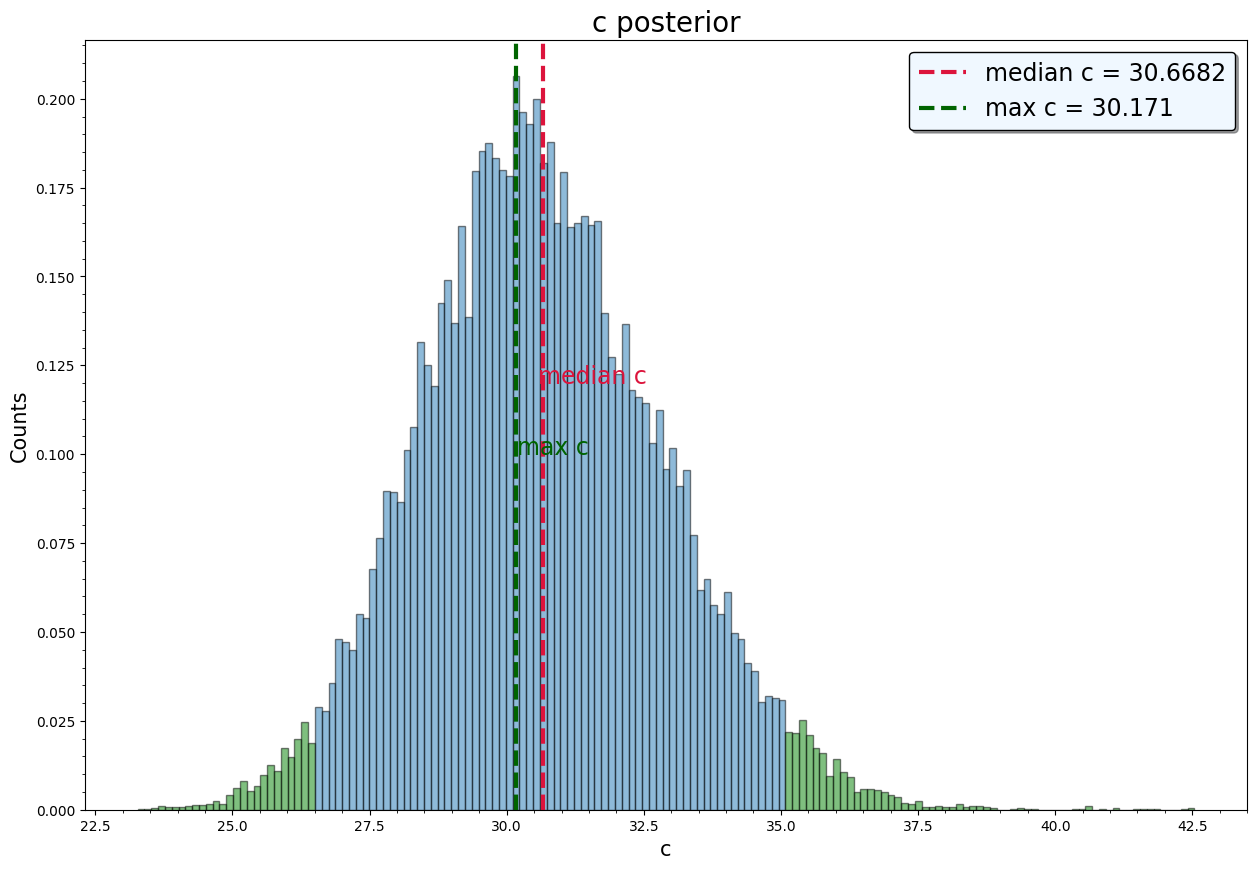

In [18]:
fig, ax, centers_c_s_r, counts_c_s_r, max_c = plot_funcs.plot_func_sim(
    chain= chain_start_sim,  parameter='c', y_max=0.1, y_median=0.12, info=False
)

Median value of  d : 0.0461
Max value of  d  : 0.0461


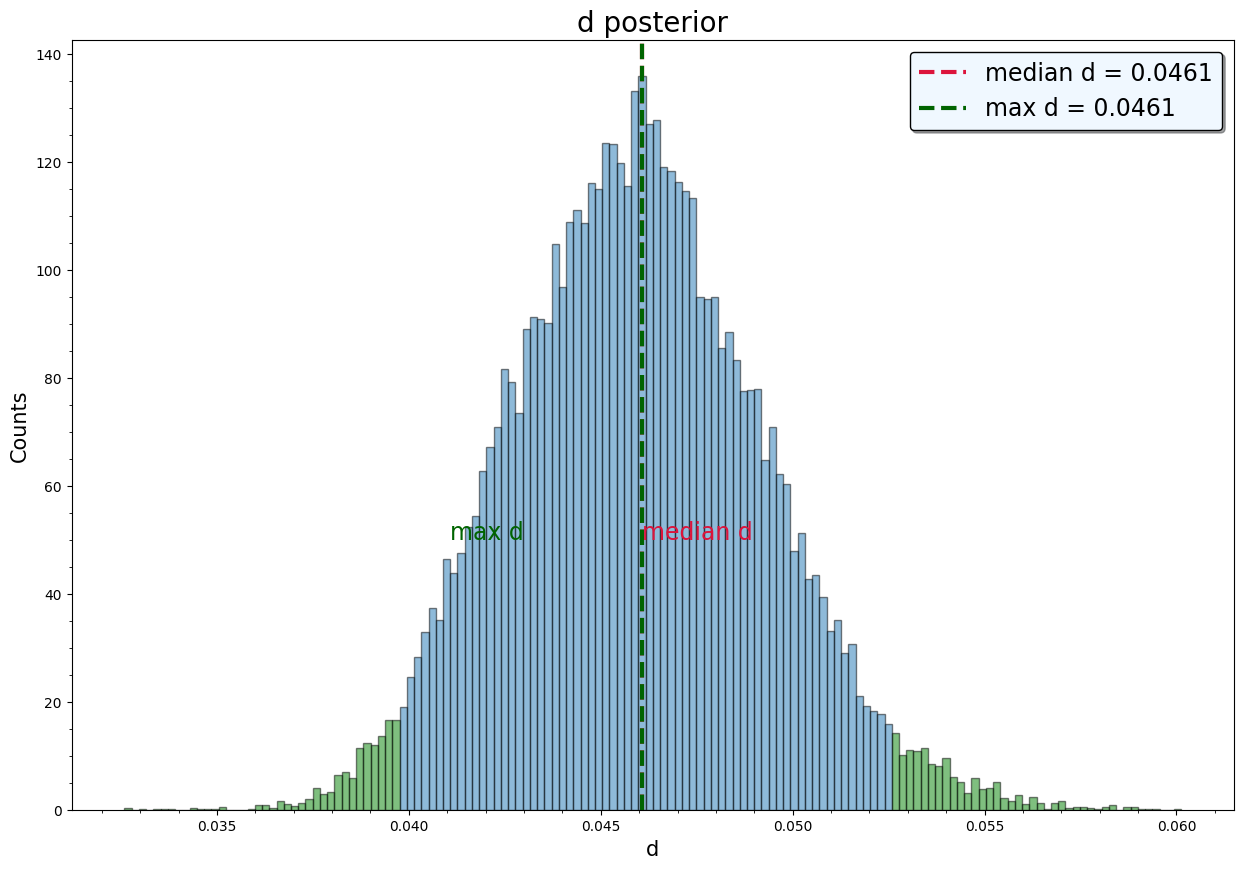

In [19]:
fig, ax,centers_d_s_r, counts_d_s_r, max_d = plot_funcs.plot_func_sim(
    chain= chain_start_sim, parameter='d', x_max=-0.005, x_median=0, y_max=50, y_median=50, info=False
)

In [20]:
print('Maximum values of the parameters:')
print('omega2 = ', round(max_omega2, 4))
print('    mu = ', round(max_mu, 4))
print('    nu = ', round(max_nu, 4))
print('     a = ', round(max_a, 4))
print('     b = ', round(max_b, 4))
print('     c = ', round(max_c, 4))
print('     d = ', round(max_d, 4))

Maximum values of the parameters:
omega2 =  2.4804
    mu =  0.6696
    nu =  0.7374
     a =  15.0841
     b =  14.9487
     c =  30.171
     d =  0.0461


## Chains

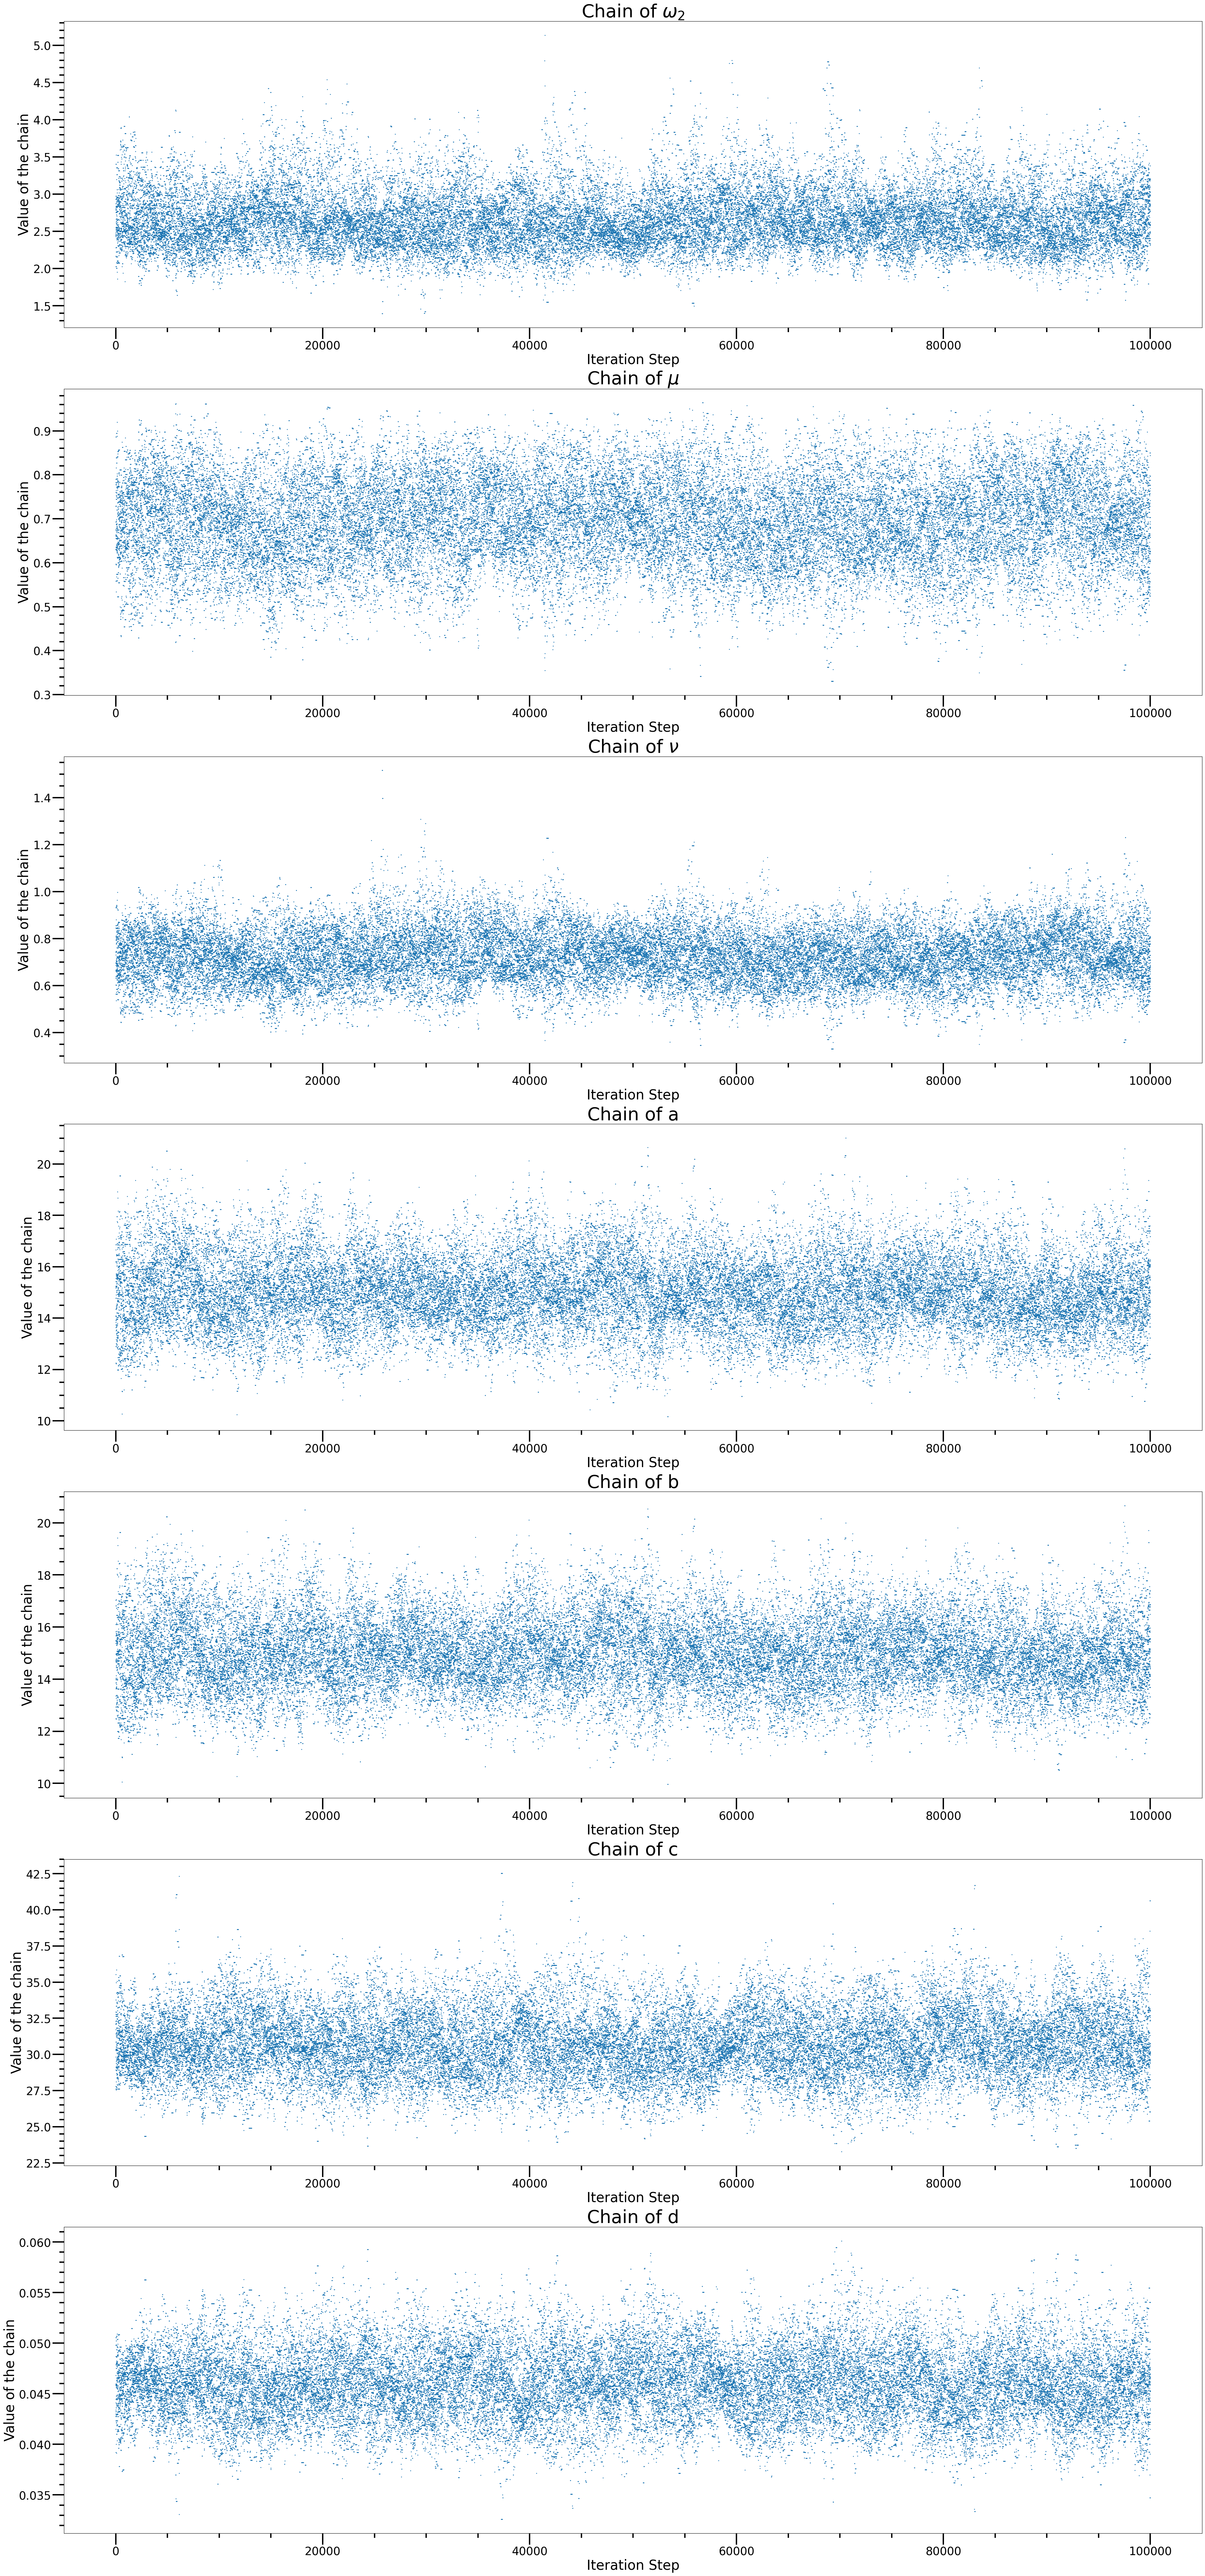

In [21]:
plot_funcs.chains_plot(chain_start_sim, info=False)
fig.tight_layout(pad=15.0)

In [22]:
# x_axis = np.linspace(0,1,1000)
# fig, ax = plt.subplots(1,1 , figsize=(15, 10))
# 
# ax.plot(x_axis, scp.stats.beta.pdf(x_axis, a=popt_b[0],b=popt_b[1]), linewidth=3)
# ax.plot(x_axis, scp.stats.beta.pdf(x_axis, a=max_a,b=max_b), linewidth=3)
# ax.scatter(div_centers, hist_val_div[0], linewidth=3, s=150, color='green', edgecolor = 'black', alpha=0.5)
# ax.axvline(0.5, color='black', linestyle='dashed',  linewidth=3) 
# ax.grid(alpha=0.5)
# ax.set_title('Division factor, Beta distribution', fontsize=20)
# ax.set_xlabel('f', fontsize=15)
# ax.minorticks_on()
# fig.tight_layout()
# plt.show()
# 
# x_axis = np.linspace(0,5,1000)
# fig, ax = plt.subplots(1,1 , figsize=(15, 10))
# 
# ax.plot(x_axis, scp.stats.gamma.pdf(x_axis, a=popt_g[0], scale=popt_g[1]), linewidth=3)
# ax.plot(x_axis, scp.stats.gamma.pdf(x_axis, a=max_c, scale=max_d), linewidth=3)
# ax.scatter(grow_centers, hist_val_grow[0], linewidth=3, s=150, color='green', edgecolor = 'black', alpha=0.5)
# ax.grid(alpha=0.5)
# ax.set_title('Growing factor, Gamma distribution', fontsize=20)
# ax.set_xlabel('$\omega_1$', fontsize=15)
# ax.minorticks_on()
# fig.tight_layout()
# plt.show()

## Simulation of the time series
Simulation of the time series using the inferred values of the parameters.

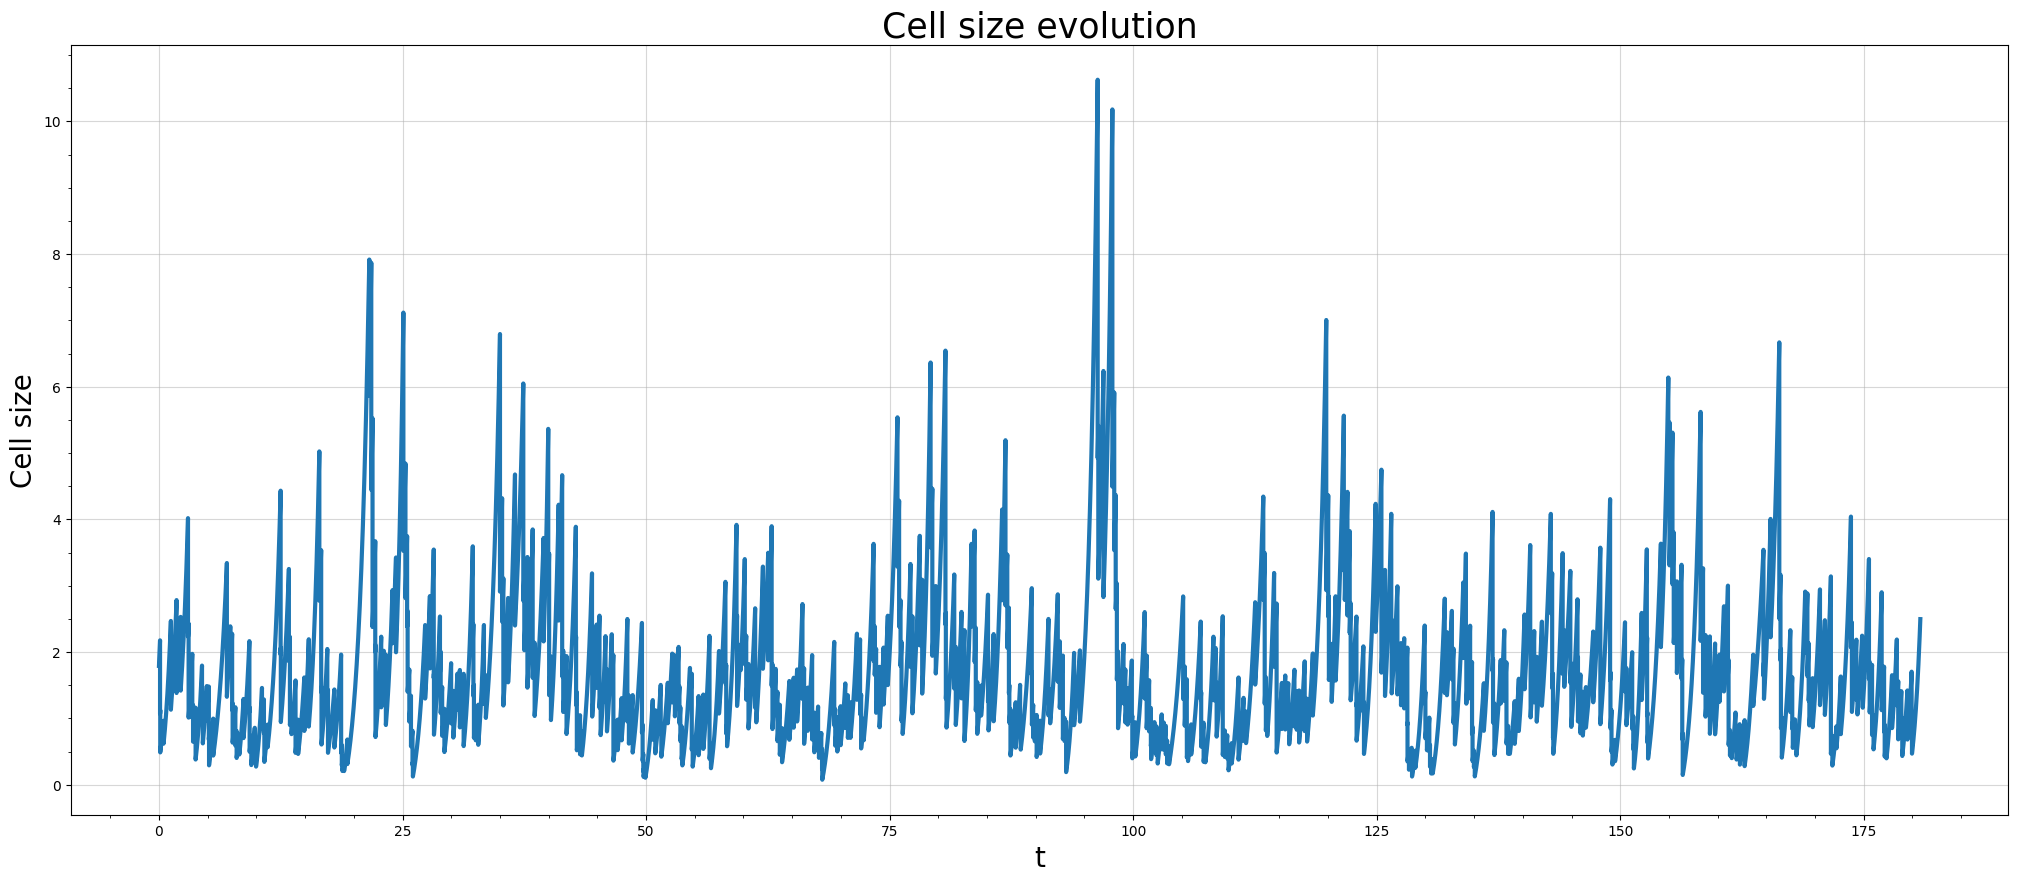

In [23]:
# simulate the time series
sim_t_starting, all_times_starting, cell_sizes_starting, frac_starting, omg1_starting = functions.sim_t_draw(
    log_CDF=functions.log_CDF_start, 
    x_function=functions.x_function_start, 
    size=500, 
    points_per_evolution=100, 
    xb=xb_realdata, 
    model = 's', 
    pars_new=(max_omega2, max_mu, max_nu, max_a, max_b, max_c, max_d)      
)

fig, ax = plot_funcs.plot_evol(all_times=all_times_starting, cell_sizes=cell_sizes_starting)

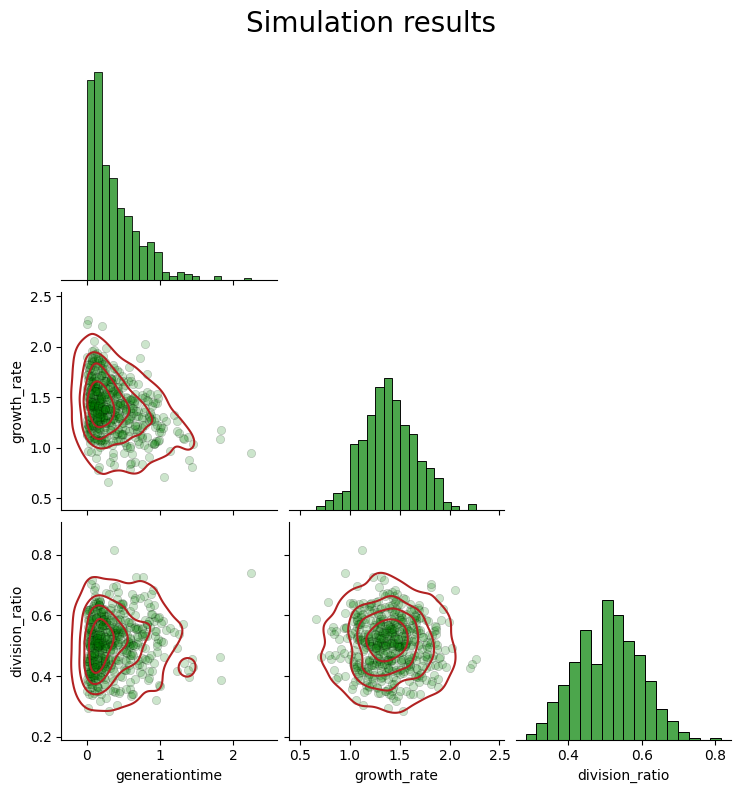

In [24]:
df_sim_starting = pd.DataFrame()
df_sim_starting['generationtime'] = sim_t_starting
df_sim_starting['growth_rate'] = omg1_starting
df_sim_starting['division_ratio'] = frac_starting


g = sns.pairplot(df_sim_starting, diag_kind="hist", corner=True, plot_kws={'color':'green', 'edgecolor':'black', 'alpha':0.2}, diag_kws={'color':'green', 'alpha':0.7})
g.map_lower(sns.kdeplot, levels=5, color="firebrick")
g.fig.suptitle('Simulation results', y=1.05, fontsize=20)
plt.show()

In [25]:
fig = plot_funcs.plot_3d_interactive(df_sim_starting, real_data_title=False)
fig.show()

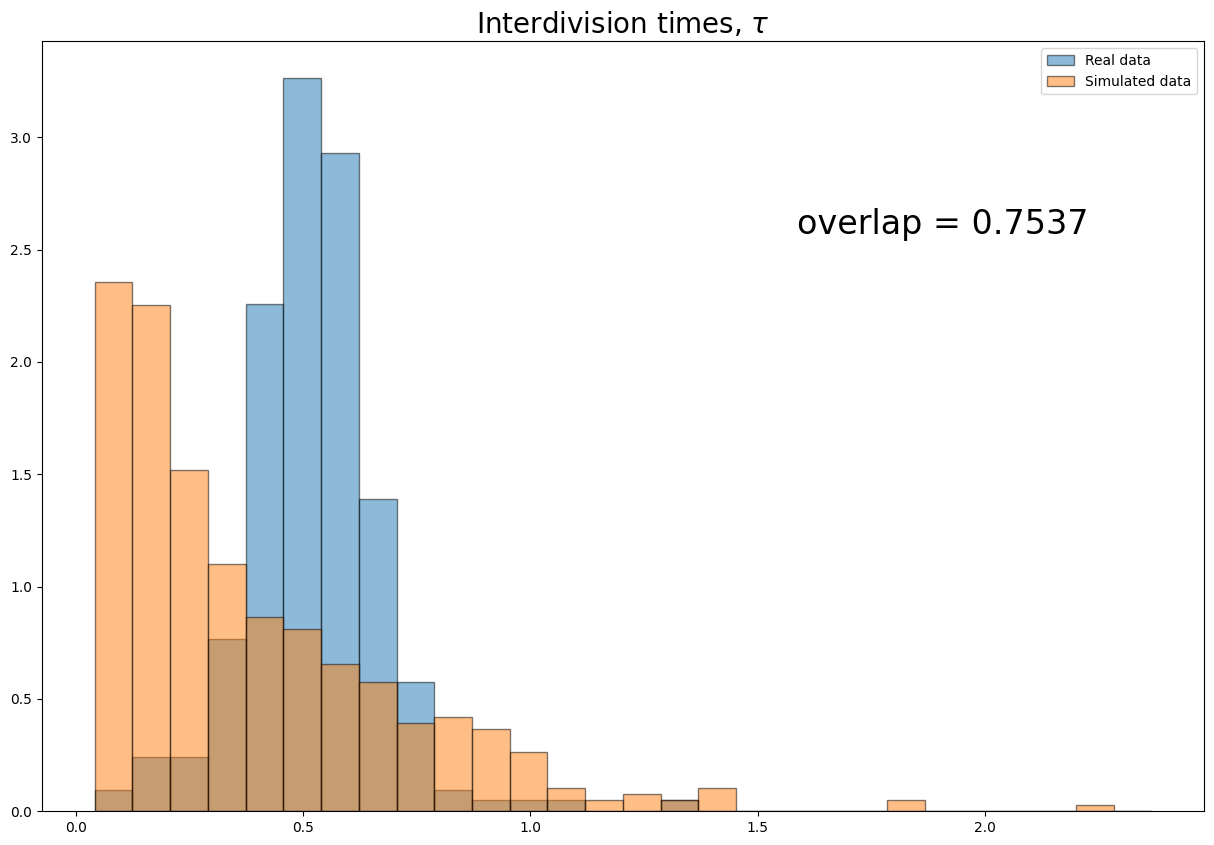

In [26]:
# overlap metrics between histograms
fig,ax = plot_funcs.overlap_hist(real_data=df_microbial_growth['generationtime'], sim_data=df_sim_starting['generationtime'])
plt.show()

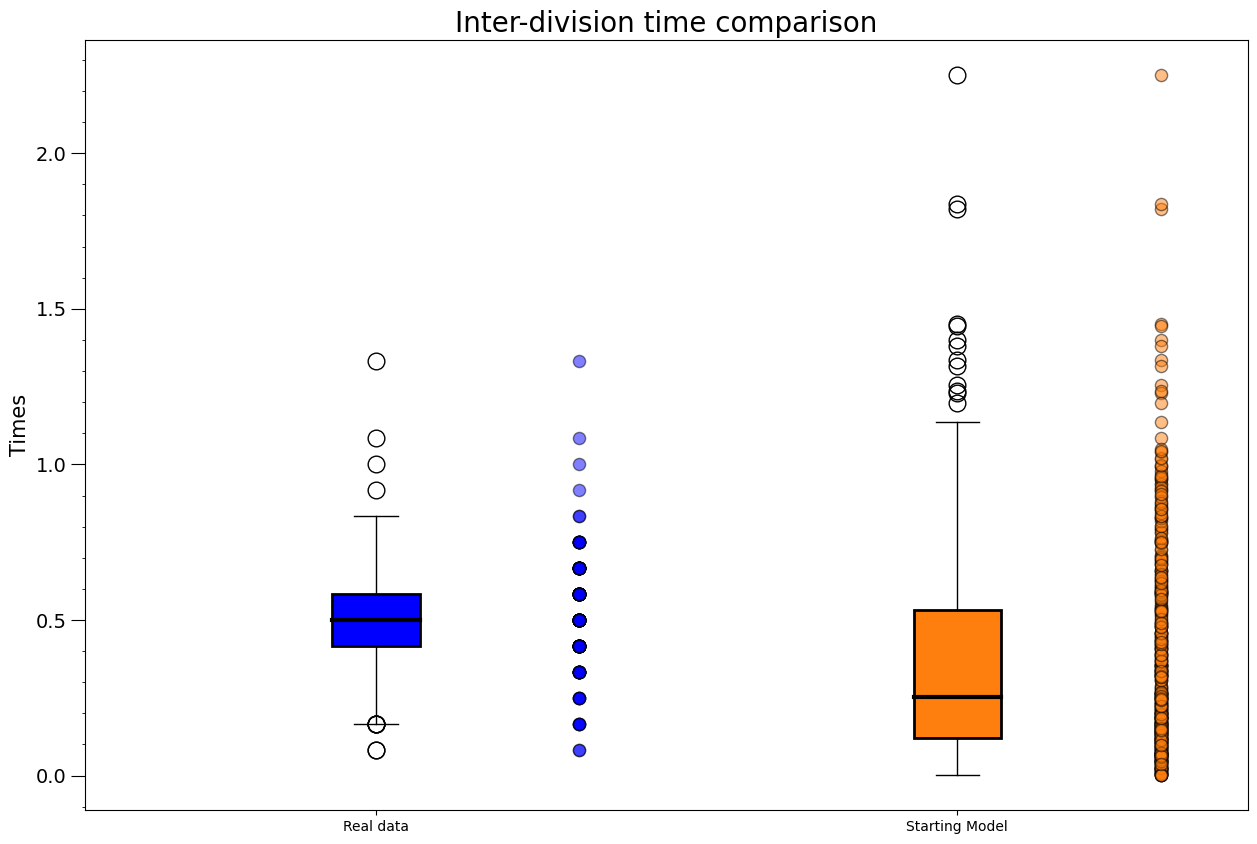

In [27]:
plot_funcs.boxplot(y=[df_microbial_growth['generationtime'], sim_t_starting], colors=['blue', 'C1'],  title = 'Inter-division time comparison', ylabel= 'Times', xlabel='', x_font= 30, labels=True, list_labels=['Real data', 'Starting Model'] )
plt.show()

## Save the interdivision times in an external file

In [28]:
# create file with the real data of the division times
filepath = '../data/timeseries.csv'
df_microbial_growth['generationtime'].rename('real_data').to_csv(filepath, index=False)

In [29]:
# add the times simulated with the starting model
df = pd.read_csv(filepath)
df['starting_model'] = df_sim_starting['generationtime']
df.to_csv(filepath, index=False)

## Simulation using $\omega_1$ and $f$ from real data



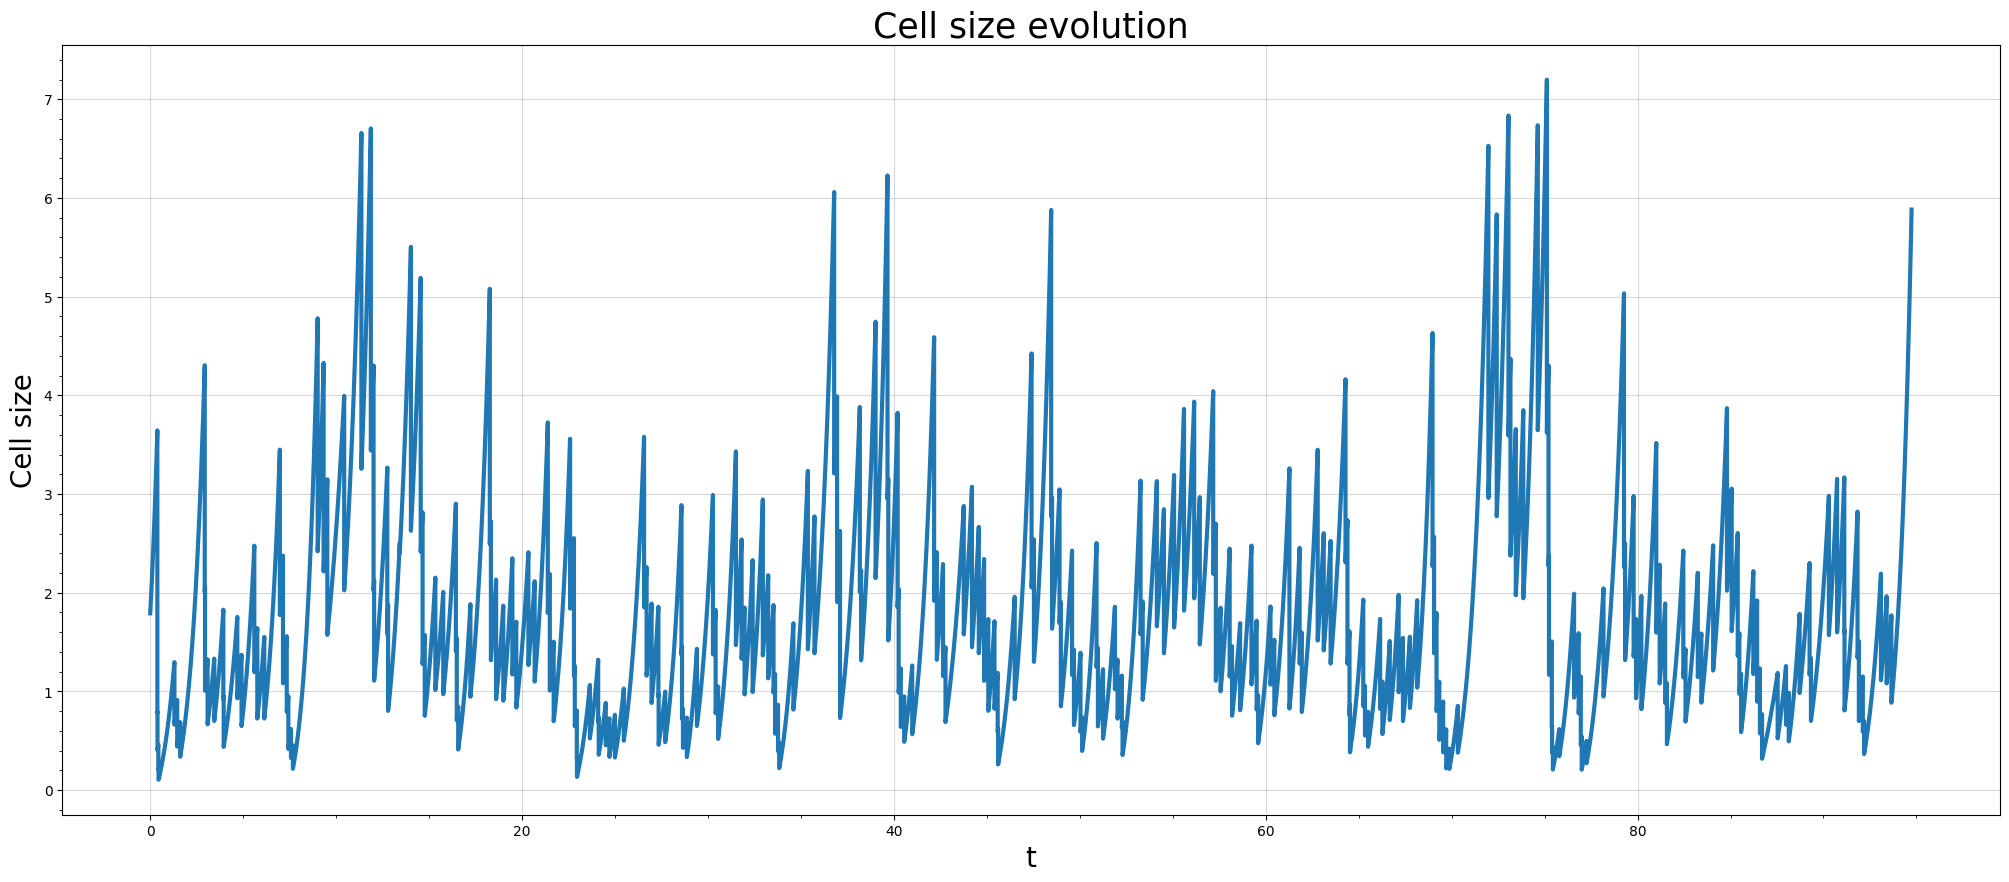

In [30]:
sim_t_start_2, all_times_start_2, cell_sizes_start_2 = functions.sim_t_draw_real(
# simulate the time series
    log_CDF=functions.log_CDF_start, 
    x_function=functions.x_function_start, 
    size=size, 
    points_per_evolution=100, 
    xb=xb_realdata, 
    frac=df_microbial_growth['division_ratio'].to_numpy(), 
    omega_1 = df_microbial_growth['growth_rate'].to_numpy(),
    model = 's', 
    pars_new=(max_omega2, max_mu, max_nu, max_a, max_b, max_c, max_d)      
)

fig, ax = plot_funcs.plot_evol(all_times=all_times_start_2, cell_sizes=cell_sizes_start_2)



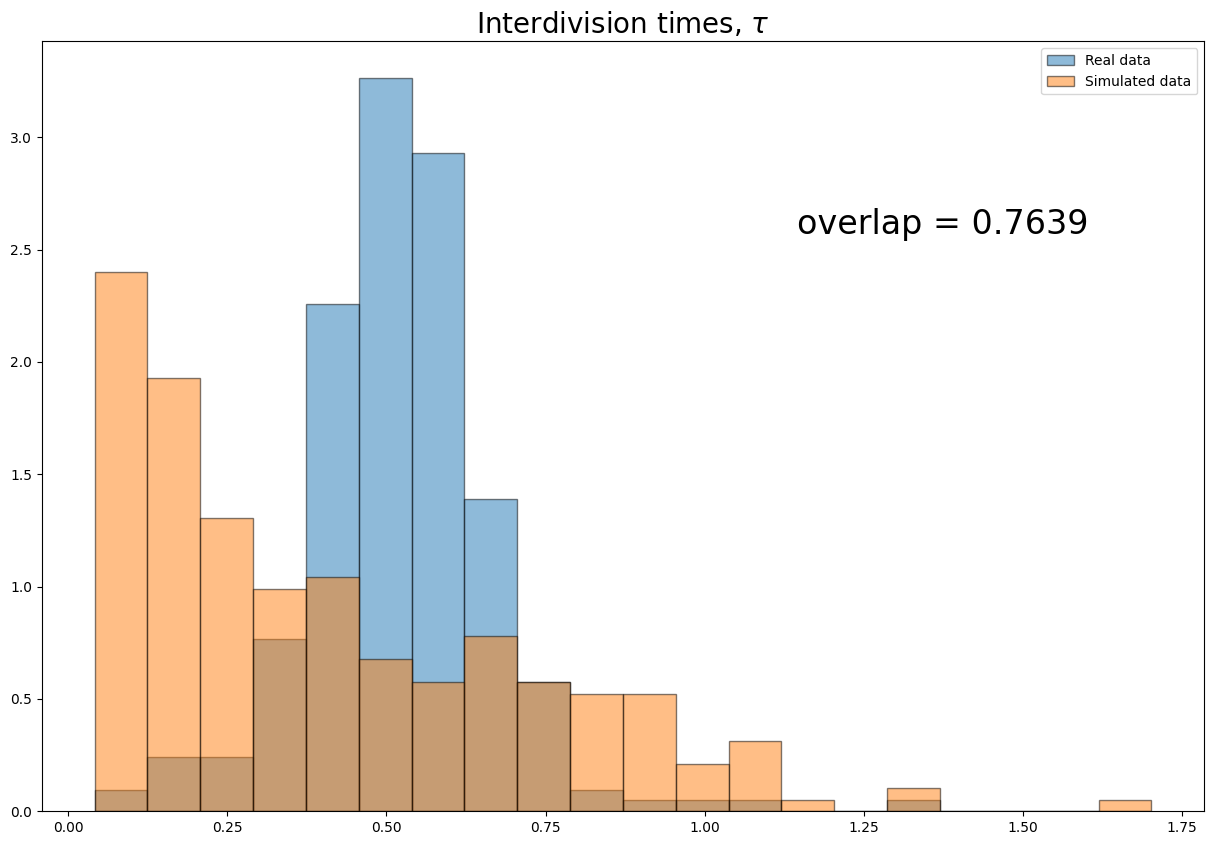

In [31]:
df_sim_start_2 = pd.DataFrame()
df_sim_start_2['generationtime'] = sim_t_start_2

# overlap metrics between histograms
fig,ax = plot_funcs.overlap_hist(
    real_data=df_microbial_growth['generationtime'], 
    sim_data=df_sim_start_2['generationtime'])
plt.show()

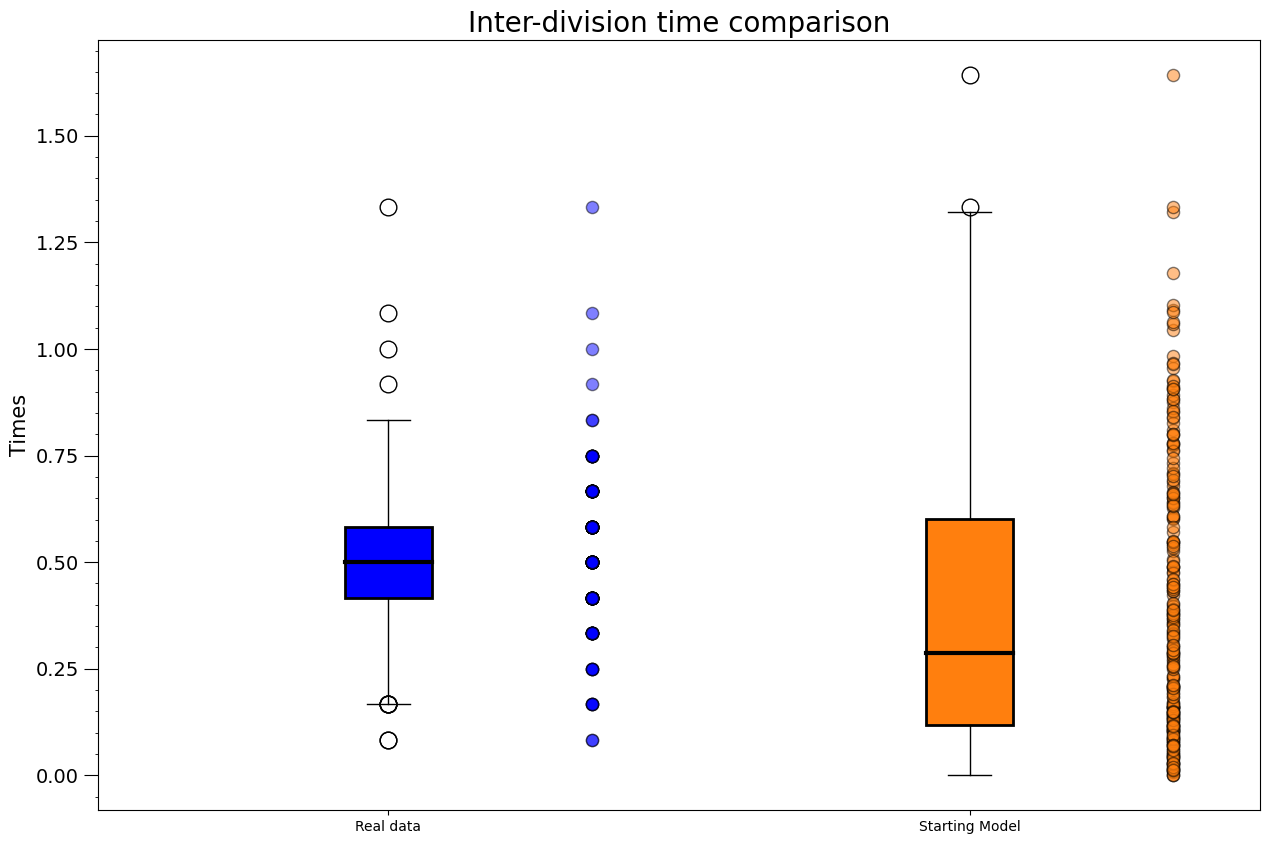

In [32]:
plot_funcs.boxplot(
    y=[df_microbial_growth['generationtime'], sim_t_start_2], 
    colors=['blue', 'C1'],  title = 'Inter-division time comparison', 
    ylabel= 'Times', xlabel='', x_font= 30, 
    labels=True, list_labels=['Real data', 'Starting Model'] )
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=52dba48d-3798-4665-95fc-01a96804955b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>